<h1> The Challenge:</h1>

Based off this dataset with school financial, enrollment, and achievement data, we are interested in what information is a useful indicator of student performance at the state level.

This question is a bit too big for a checkpoint, however. Instead, we want you to look at smaller questions related to our overall goal. Here's the overview:

1. Choose a specific test to focus on
>Math/Reading for 4/8 grade
* Pick or create features to use
>Will all the features be useful in predicting test score? Are some more important than others? Should you standardize, bin, or scale the data?
* Explore the data as it relates to that test
>Create 2 well-labeled visualizations (graphs), each with a caption describing the graph and what it tells us about the data
* Create training and testing data
>Do you want to train on all the data? Only data from the last 10 years? Only Michigan data?
* Train a ML model to predict outcome 
>Pick if you want to do a regression or classification task. For both cases, defined _exactly_ what you want to predict, and pick any model in sklearn to use (see sklearn <a href="https://scikit-learn.org/stable/modules/linear_model.html">regressors</a> and <a href="https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html">classifiers</a>).
* Summarize your findings
>Write a 1 paragraph summary of what you did and make a recommendation about if and how student performance can be predicted

** Include comments throughout your code! Every cleanup and preprocessing task should be documented.


Of course, if you're finding this assignment interesting (and we really hope you do!), you are welcome to do more than the requirements! For example, you may want to see if expenditure affects 4th graders more than 8th graders. Maybe you want to look into the extended version of this dataset and see how factors like sex and race are involved. You can include all your work in this notebook when you turn it in -- just always make sure you explain what you did and interpret your results. Good luck!

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feel free to import other libraries! 

In [69]:
df = pd.read_csv('../data/states_edu.csv')

df.head()
df.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'],
      dtype='object')

Chosen test: AVG_MATH_4_SCORE

<h2> Cleanup (optional)</h2>

_Use this space to rename columns, deal with missing data, etc._

In [70]:
# rename our columns to make them more intuitive
df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST'
    },
    axis=1,inplace=True)



#Look at na values for prek
df['ENROLL_PREK'].isna().sum() #78
#Can we figure this out based on other enrollments?

#Look at na values for prek
df['ENROLL_ALL'].isna().sum() #74

# We know from tutorial that data missing ENROLL_ALL is also missing all other enrollment data
df[df.ENROLL_ALL.isna()][['ENROLL_PREK','ENROLL_PRIMARY','ENROLL_HS','ENROLL_ALL_EST']].notna().any()

#Look at na values for instruction_expenditure
df['INSTRUCTION_EXPENDITURE'].isna().sum() #51

#Remove records where we don't have ENROLL_PREK, AVG_MATH_4_SCORE, and INSTRUCTION_EXPENDITURE
df.dropna(subset=['AVG_MATH_4_SCORE','ENROLL_PREK','INSTRUCTION_EXPENDITURE'], inplace=True)
df.shape 
#(436,25)

       
    


(436, 25)

<h2> Feature Selection </h2>

_Use this space to modify or create features_

In [71]:
#Let's see if pre-k enrollment impacts scores
#This is a bit of a reach because this is current pre-k enrollment, not pre-k enrollment for this 
#group of 4th graders

#Look at pre-k enrollment as a percentage of total enrollment
df['pct_prek']= df['ENROLL_PREK']/df['ENROLL_ALL']
#print(df['pct_prek'])
                                    
#Create a field for show the percent of total expenditure spent on instruction 
df['pct_instruction_expenditure']=df['INSTRUCTION_EXPENDITURE'] / df['TOTAL_EXPENDITURE']

df['pct_instruction_expenditure'].isna().sum() #0  


#Let's also look at total_expenditure per student
df['expenditure_per_student']=df['TOTAL_EXPENDITURE'] / df['ENROLL_ALL']
df['expenditure_per_student']
    

0        3.627221
2        5.050774
3        3.948044
4        5.164536
5        5.329154
          ...    
1219    12.553239
1220    12.538879
1221    12.495787
1222    13.313755
1223    20.507470
Name: expenditure_per_student, Length: 436, dtype: float64

Final feature list: **<pct_prek, pct_instruction_expenditure, expenditure_per_student, YEAR>**

Feature selection justification: 
pct_prek: Although this is looking at the percent of pre_k students in the state now, as opposed to when these 4th graders went to pre_k, it might be interesting to see if states with a higher pre_k enrollment score higher on the stests

pct_instruction_expenditure: Does the percent of total expenditure that is directed at instruction make a difference in the score?

expenditure_per_student: If we look at total expenditure for the state for the year and divide it by total enrollment, does this expenditure per student amount impact the score?

YEAR: Does the year that students took the test impact the score?

<h2> EDA </h2>

Visualization 1

Text(0.5, 1.0, 'Distribution of 4th grade math scores')

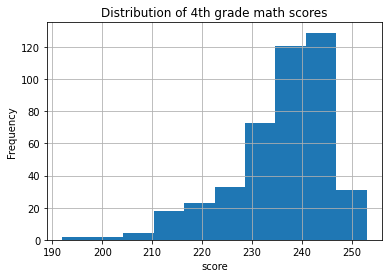

In [72]:
#Look at the distribution of the 4th grade math score
df.AVG_MATH_4_SCORE.hist()
plt.xlabel('score')
plt.ylabel('Frequency')
plt.title('Distribution of 4th grade math scores')

**<Distribution of 4th grade math scores>**

Visualization 2

<AxesSubplot:xlabel='expenditure_per_student', ylabel='AVG_MATH_4_SCORE'>

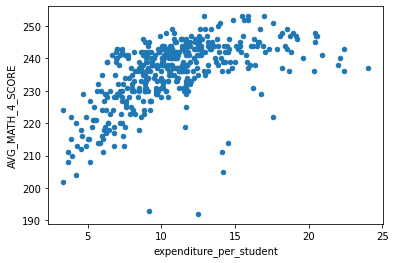

In [73]:
df.plot.scatter(x='expenditure_per_student',y='AVG_MATH_4_SCORE')

**<4th Grade Math Score Based on Expenditure Per Student>**

<h2> Data Creation </h2>

_Use this space to create train/test data_

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X = df[['pct_prek','pct_instruction_expenditure','expenditure_per_student','YEAR']].dropna()

y = df.loc[X.index]['AVG_MATH_4_SCORE']

In [76]:
df.AVG_MATH_4_SCORE.describe()

count    436.000000
mean     235.591743
std        9.922612
min      192.000000
25%      230.000000
50%      238.000000
75%      243.000000
max      253.000000
Name: AVG_MATH_4_SCORE, dtype: float64

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=.3, random_state=0)

<h2> Prediction </h2>

Chosen ML task: **<REGRESSION>**

In [78]:
# import your sklearn class here
from sklearn.linear_model import LinearRegression

In [79]:
# create your model here
model = LinearRegression()

In [80]:
model.fit(X_train, y_train)

LinearRegression()

In [81]:
print('intercept is: ',model.intercept_)
print('coefficents are: ',model.coef_)

y_pred = model.predict(X_test)

# R**2 value describes how well a linear model fits the data
print('model.score(X_test, y_test) is: ',model.score(X_test, y_test))
print('mean error: ',np.mean(model.predict(X_test)-y_test))
print('mean absolute error: ',np.mean(np.abs(model.predict(X_test)-y_test)))
print('root mean squared error: ',np.mean((model.predict(X_test)-y_test)**2)**0.5)

intercept is:  -1618.3740391223935
coefficents are:  [-100.45829879   18.47604053    0.67811686    0.91668665]
model.score(X_test, y_test) is:  0.6315811445154937
mean error:  0.020871515489834357
mean absolute error:  5.003201605198629
root mean squared error:  6.293788904137429


Text(0, 0.5, '4th Grade Math Score')

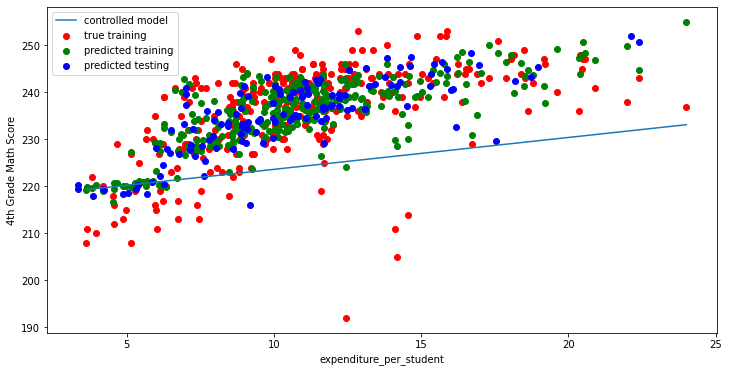

In [87]:
# FOR REGRESSION ONLY: (pick a single column to visualize results)

# Results from this graph _should not_ be used as a part of your results -- it is just here to help with intuition. 
# Instead, look at the error values and individual intercepts.


col_name = 'expenditure_per_student'
col_index = X_train.columns.get_loc(col_name)

f = plt.figure(figsize=(12,6))
plt.scatter(X_train[col_name], y_train, color = "red")
plt.scatter(X_train[col_name], model.predict(X_train), color = "green")
plt.scatter(X_test[col_name], model.predict(X_test), color = "blue")

new_x = np.linspace(X_train[col_name].min(),X_train[col_name].max(),200)
intercept = model.predict([X_train.sort_values(col_name).iloc[0]]) - X_train[col_name].min()*model.coef_[col_index]
plt.plot(new_x, intercept+new_x*model.coef_[col_index])

plt.legend(['controlled model','true training','predicted training','predicted testing'])
plt.xlabel(col_name)
plt.ylabel('4th Grade Math Score')

In [83]:



# FOR CLASSIFICATION ONLY:
from sklearn.metrics import plot_confusion_matrix

#plot_confusion_matrix(model, X_test, y_test,
     #                    cmap=plt.cm.Blues)

<h2> Summary </h2>

The regression coefficients show that the pre_k percentage has a negative relationship with the 4th grade math score. This is strange, but the use of that variable was noted to be questionable. The other three variables do have a positive impact on the 4th grade math score, with pct_instruction_expenditure having the most impact. 

If I understood the tutorial video correctly, the root mean squared error shows that the 4th grade math score should go up by 6 points if each of the variables go up by one unit. 